In [1]:
"""
Use this notebook to create DL pipeline
"""

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [2]:
# define data paths
path = r"C:/Users/Public/saved_images/"
file_path_real = r"C:/Users/Public/saved_images/real/"
file_path_gt = r"C:/Users/Public/saved_images/gt/"
# current image size
img_size_w = 1920
img_size_h = 1080

img_size = 1080

In [3]:
"""stuff to load images into X, y format"""

H = 256
W = 256

def process_data(path):
    images = sorted(glob(os.path.join(path, "real/*")))
    masks = sorted(glob(os.path.join(path, "gt/*")))

    return images, masks

def load_data(path):
    #train_valid_path = os.path.join(path, "annotations/trainval.txt")
    #test_path = os.path.join(path, "annotations/test.txt")

    train_x, train_y = process_data(path)
    test_x, test_y = process_data(path)

    train_x, valid_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=0.2, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x - 1
    x = x.astype(np.int32)
    return x

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])

    return image, mask
    

In [4]:

def look_at_data_gen():
    """test the datagen out"""
    path = r"C:/Users/Public/saved_images/"
    
    images, masks = load_data(path)
    print(f"Images: {len(images)} - Masks: {len(masks)}")
    
    dataset = tf_dataset(images, masks, batch=3)
    for x, y in dataset:
        
        x = x[0]
        y = y[0]
        
        x = x.numpy()
        y = y.numpy()
        y= np.squeeze(y, axis=-1)
        
        x = x * 255.0
        y = y * 255.0
        
        print(x,y)
        
#look_at_data_gen()

def look_at_new_data_gen():
    path = r"C:/Users/Public/saved_images/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    dataset = tf_dataset(train_x, train_y, batch=8)
    for x, y in dataset:
        print(x.shape, y.shape) ## (8, 256, 256, 3), (8, 256, 256, 3)

#look_at_new_data_gen()

In [5]:
"""build UNET"""

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

# look at model

model = build_unet((256, 256, 3), 10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 128)  147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 up_sampli

                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 16  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 16  2320        ['activation_16[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 16  64         ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

In [6]:
"""train the model"""
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)
path = r"C:/Users/Public/saved_images/"

""" Dataset """
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

""" Hyperparameters """
shape = (256, 256, 3)
num_classes = 3
lr = 1e-4
batch_size = 8
epochs = 10

""" Model """
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks
)

Dataset: Train: 4000 - Valid: 1000 - Test: 5000
Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 3.7261e-05
Epoch 1: saving model to model.h5
500/500 [==============================] - 310s 609ms/step - loss: 3.7261e-05 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 3.8739e-05
Epoch 2: saving model to model.h5
500/500 [==============================] - 307s 615ms/step - loss: 3.8739e-05 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 4.1087e-05
Epoch 3: saving model to model.h5
500/500 [==============================] - 299s 600ms/step - loss: 4.1087e-05 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 4.1780e-05
Epoch 4: saving model to model.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
500/500 [==============================] - 300s 600ms/step - 

In [9]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.int32, name=None))>

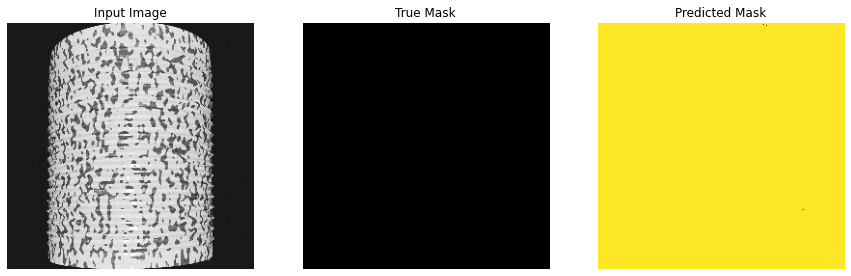

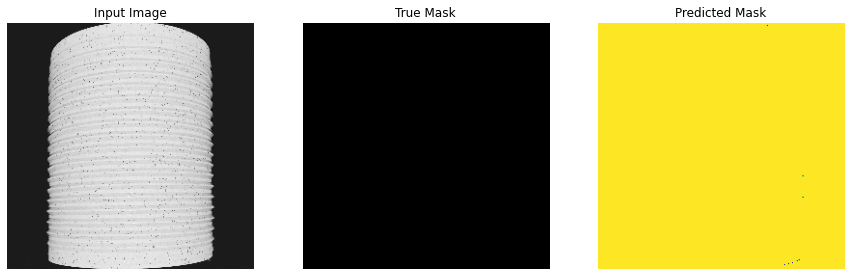

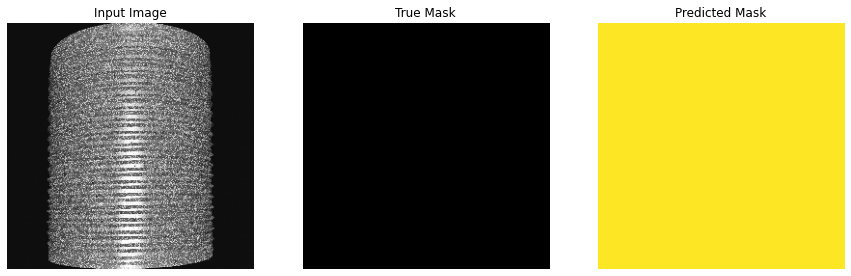

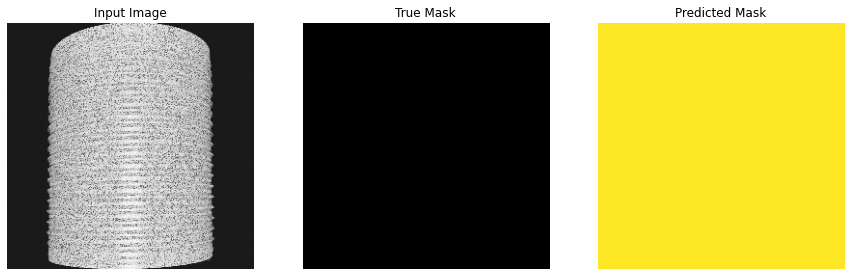

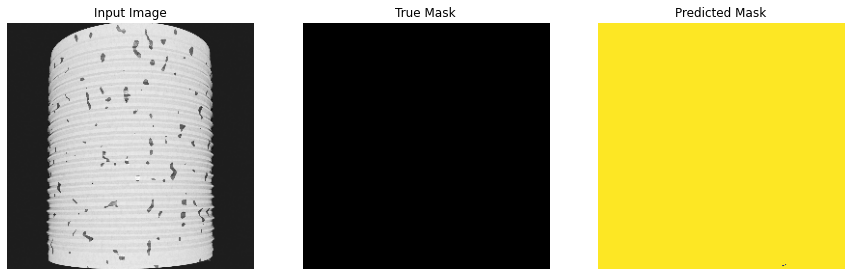

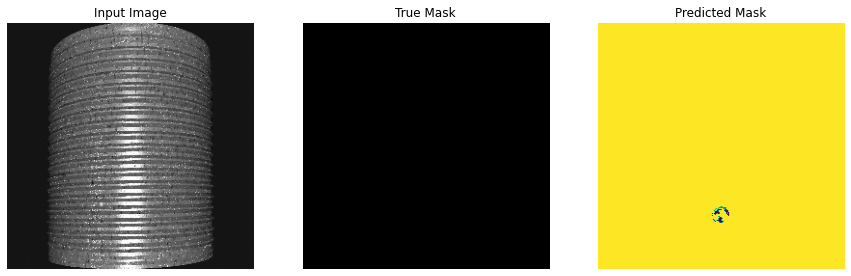

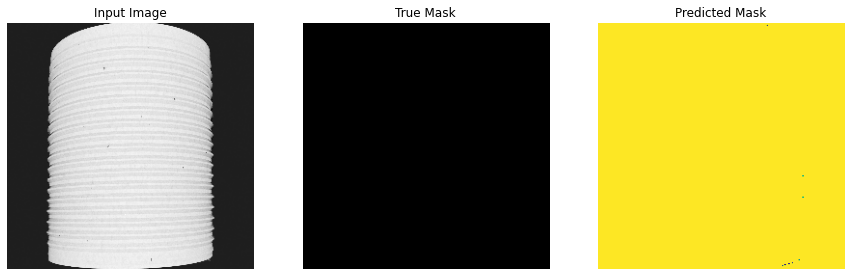

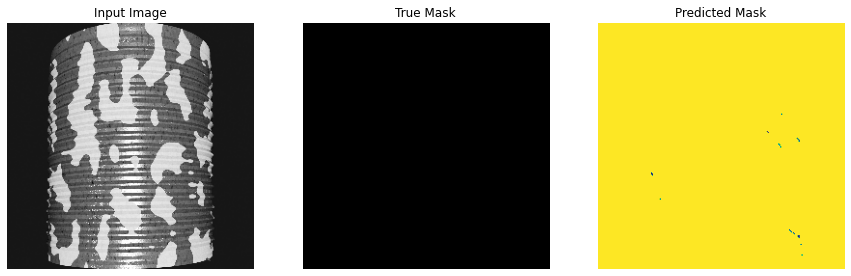

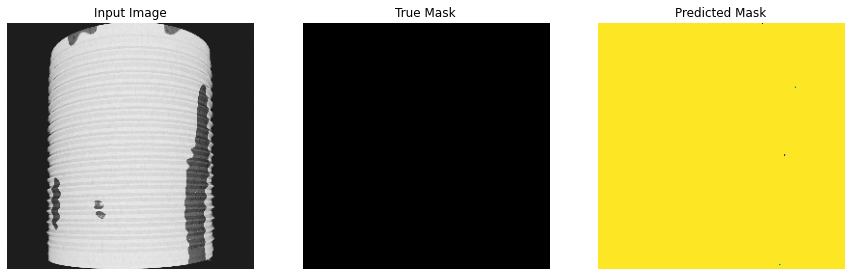

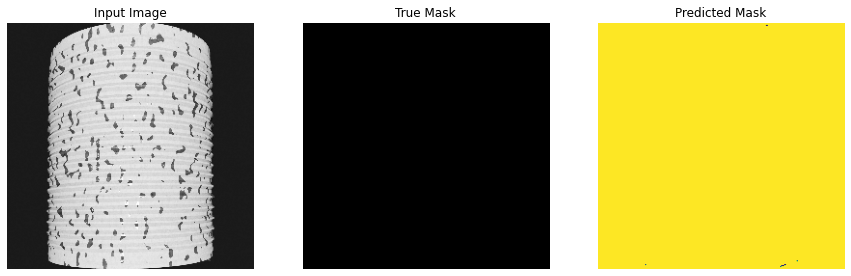

In [13]:
"""
Evaluate model performance.
"""
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(valid_dataset, 10)


In [ ]:
"""
OLD STUFF BELOW, TENSORFLOW STUFF
"""

In [ ]:
"""https://www.tensorflow.org/tutorials/images/segmentation"""
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:

from IPython.display import clear_output
import matplotlib.pyplot as plt

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# make data

path = r"C:/Users/Public/saved_images/"
    
images, masks = load_data(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")
    
dataset = tf_dataset(images, masks, batch=1000)

#TRAIN_LENGTH = info.splits['train'].num_examples
TRAIN_LENGTH = 100

BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [ ]:
dataset['images']

In [ ]:
# not sure this is needed since we have the tf data generator

#train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
#test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
"""define the model"""

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
"""take a quick peek at the model... its a U"""
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
# show predictions
show_predictions()


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
"""plot loss"""
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3)


In [ ]:
# optional stuff not included...